# Sentinel-2 dataset processing

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import tifffile as tiff

import tensorflow as tf

2023-12-07 16:03:30.456055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 16:03:30.456117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 16:03:30.493549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 16:03:30.573345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:03:31.768409: W tensorflow/compiler/tf2

In [2]:
# Specify the path to the image and mask files
IMG_FILE = Path("/home/enzo/tensorflow_datasets/downloads/manual/sentinel_water/2018.04/rgb_nir/rgb_nir.tif")
MASK_FILE = Path("/home/enzo/tensorflow_datasets/downloads/manual/sentinel_water/label.tif")

BLOCK_DIR = Path("/home/enzo/tensorflow_datasets/downloads/manual/sentinel_water/blocks")
MASK_DIR = Path("/home/enzo/tensorflow_datasets/downloads/manual/sentinel_water/masks")

# if BLOCK_DIR and MASK_DIR do not exist, create them
if not os.path.exists(BLOCK_DIR):
    os.makedirs(BLOCK_DIR)
if not os.path.exists(MASK_DIR):
    os.makedirs(MASK_DIR)

In [3]:
print(BLOCK_DIR)

/home/enzo/tensorflow_datasets/downloads/manual/sentinel_water/blocks


In [4]:
## Create blocks from the image and mask files

# Load the image and mask files
img = tiff.imread(IMG_FILE)
mask = tiff.imread(MASK_FILE)

block_size = 1024
overlap = 0.25 * block_size


n_blocks_x = int(np.ceil(img.shape[1] / overlap)) 
n_blocks_y = int(np.ceil(img.shape[0] / overlap))

In [8]:
# Iterate over the image rows and columns, slicing the image into chunks with overlap
counter = 0

for i in range(n_blocks_y):
    for j in range(n_blocks_x):
        x1 = int(j*overlap)  
        x2 = int(min(x1 + block_size, img.shape[1]))
        y1 = int(i*overlap)
        y2 = int(min(y1 + block_size, img.shape[0]))
        
        block = img[y1:y2, x1:x2, :]
        mask_block = mask[y1:y2, x1:x2]
        mask_block = np.expand_dims(mask_block, axis=-1)
        if block.shape[0] >= block_size and block.shape[1] >= block_size:
            block = tf.image.resize(block, [256, 256])
            mask_block = tf.image.resize(mask_block, [256, 256])
            # convert back to numpy array
            block = block.numpy()
            mask_block = mask_block.numpy()
            tiff.imwrite(os.path.join(BLOCK_DIR, f"{counter}.tif"), block)
            tiff.imwrite(os.path.join(MASK_DIR, f"{counter}.tif"), mask_block)
            counter += 1


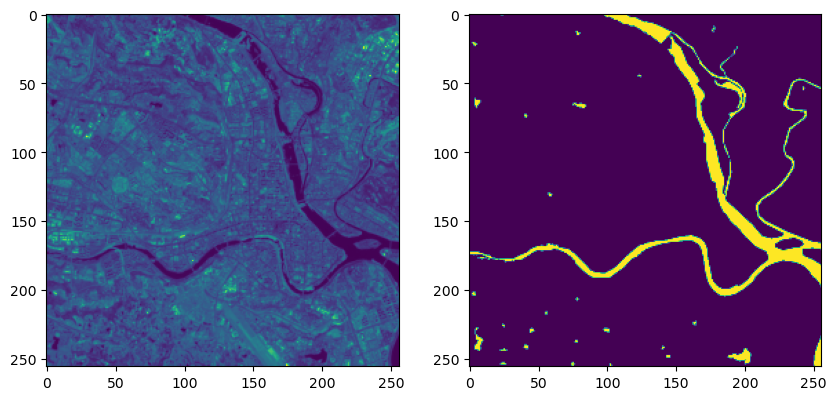

In [11]:
block = tiff.imread(os.path.join(BLOCK_DIR, "456.tif"))
mask_block = tiff.imread(os.path.join(MASK_DIR, "456.tif"))

# normalize the block images
normalized_image = (block - block.min()) / (block.max() - block.min())

# plot block and mask side by side
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(normalized_image[:, :, :3])
ax[1].imshow(mask_block)
plt.show()

In [17]:
block.shape

(1024, 1024, 4)